# Лаборатная работа 5
**Выполнила:** Сидельникова Дарья

Библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("lab5.csv")
df

,Date,Employees
0,1/1/1990,1064.5
1,2/1/1990,1074.5
2,3/1/1990,1090.0
3,4/1/1990,1097.4
4,5/1/1990,1108.7
...,...,...
343,8/1/2018,2019.1
344,9/1/2018,1992.5
345,10/1/2018,1984.3
346,11/1/2018,1990.1


Смотрим информацию

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       348 non-null    object 
 1   Employees  348 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.6+ KB


- Пропусков нет

In [ ]:
df.describe( include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,348,348,12/1/2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Employees,348.0,NaN,NaN,NaN,1452.506897,256.604914,1064.5,1238.05,1436.2,1586.3,2022.1


Предварительный анализ и визуализация

In [ ]:
date_col = None
y_col = None
for c in df.columns:
    cl = c.lower().strip()
    if cl in "date":
        date_col = c if date_col is None else date_col
    if cl in "employees":
        y_col = c if y_col is None else y_col
if date_col is None:
    for c in df.columns:
        if not np.issubdtype(df[c].dtype, np.number):
            date_col = c; break
if y_col is None:
    for c in df.columns:
        if np.issubdtype(df[c].dtype, np.number):
            y_col = c; break

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col, y_col]).sort_values(date_col)
df = df.rename(columns={y_col:"y"})
df = df.set_index(date_col)


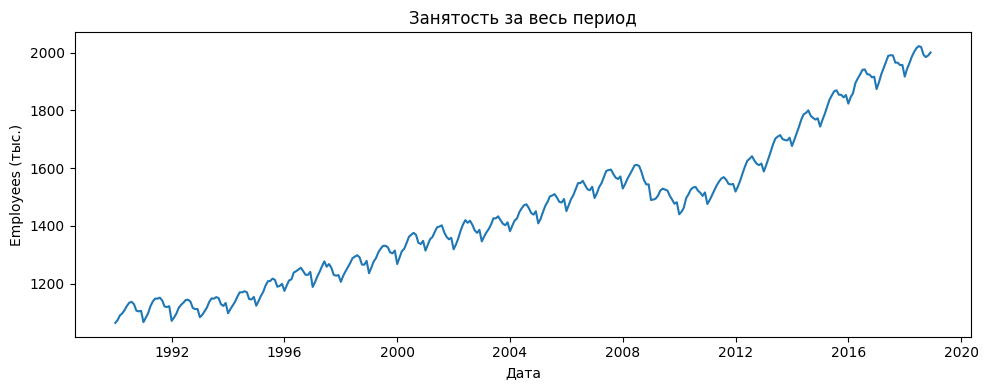

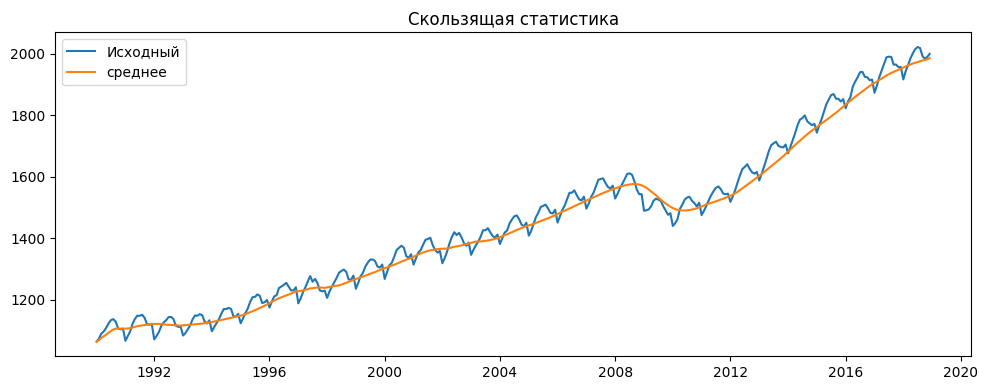

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df)
plt.title("Занятость за весь период")
plt.xlabel("Дата"); plt.ylabel("Employees (тыс.)")
plt.tight_layout(); plt.show()

roll_mean = df.rolling(12, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(df, label="Исходный")
plt.plot(roll_mean, label="среднее")
plt.legend(); plt.title("Скользящая статистика")
plt.tight_layout(); plt.show()

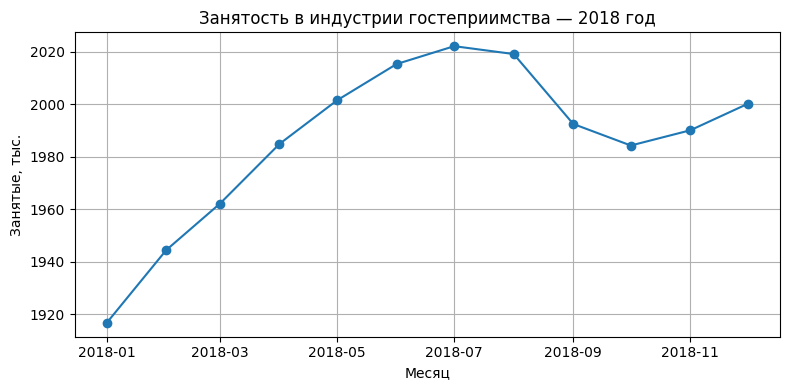

,y
Date,
2018-01-01,1916.8
2018-02-01,1944.5
2018-03-01,1962.2
2018-04-01,1984.9
2018-05-01,2001.5
2018-06-01,2015.3
2018-07-01,2022.1
2018-08-01,2019.1
2018-09-01,1992.5


In [ ]:
last_year = df.index.max().year
df_year = df[df.index.year == last_year]

plt.figure(figsize=(8,4))
plt.plot(df_year.index, df_year["y"], marker="o")
plt.title(f"Занятость в индустрии гостеприимства — {last_year} год")
plt.xlabel("Месяц")
plt.ylabel("Занятые, тыс.")
plt.grid(True)
plt.tight_layout()
plt.show()

df_year

Видно сезонные колебания в занятости, веротяно зима-лето, но тренд на обоих графиках лонговый

12м среднее идет лаконично с исходными данными, а отлонение совсем внизу, что говорит об отсутствии воллатильности, идем четко ровно без прострелов

**Декомпозиция**

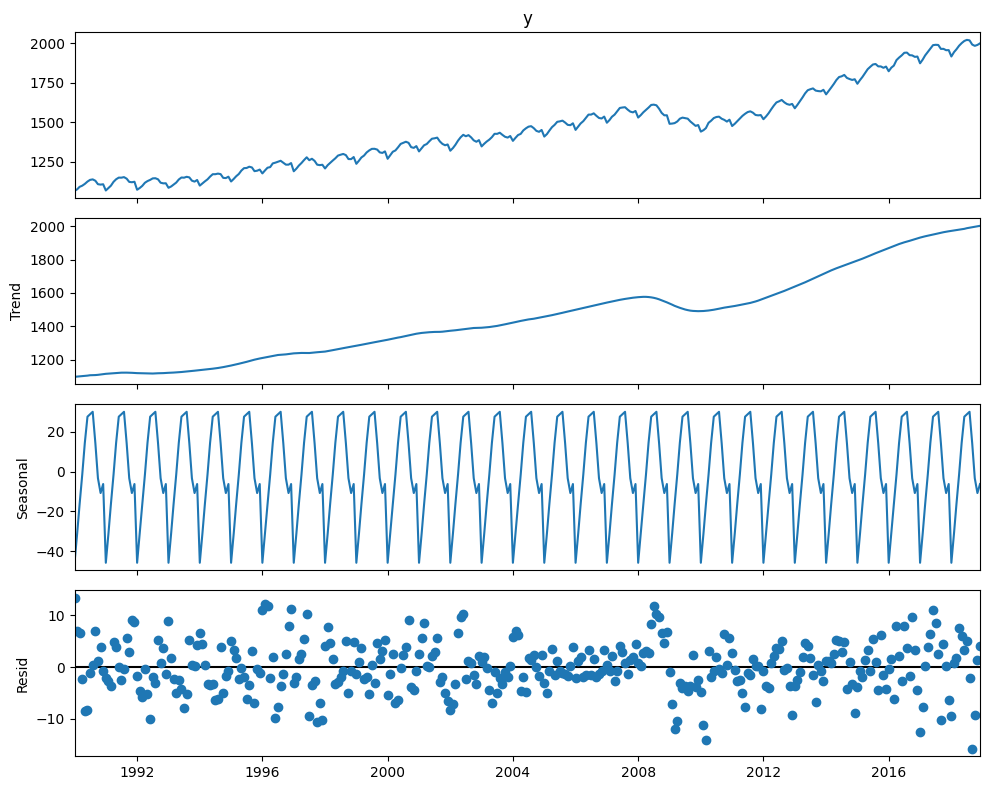

In [ ]:
res = seasonal_decompose(df["y"], model="additive", period=12, extrapolate_trend="freq")
fig = res.plot()
fig.set_size_inches(10,8)
plt.tight_layout(); plt.show()


Тренд ярко выраженный, даже трендовую три раз не потрогали

Сезонность присутсвует, монжо заметить по колебаниям - цикл постоянно повторяется

Шум - остаток присутсвует



ADF

In [ ]:
def safe_adf(series, name):
    try:
        stat = adfuller(series.dropna(), autolag="AIC")
        return {"name": name, "ADF": stat[0], "p-value": stat[1], "lags": stat[2], "nobs": stat[3]}
    except Exception as e:
        return {"name": name, "error": str(e)}

do_log = (df["y"] > 0).all()
y_tr = np.log(df["y"]) if do_log else df["y"].copy()

adf_tbl = pd.DataFrame([
    safe_adf(df["y"], "Исходный ряд"),
    safe_adf(y_tr, "Логарифм" if do_log else "Без логарифма"),
    safe_adf(y_tr.diff(1), "1-я разность"),
    safe_adf(y_tr.diff(12), "Сезонная разность"),
    safe_adf(y_tr.diff(1).diff(12), "1-я + сезонная"),
])
display("Результаты ADF", adf_tbl)


'Результаты ADF'

,name,ADF,p-value,lags,nobs
0,Исходный ряд,0.901284,9.931071e-01,17,330
1,Логарифм,0.376334,9.805880e-01,17,330
2,1-я разность,-3.273291,1.611540e-02,17,329
3,Сезонная разность,-2.931381,4.181858e-02,15,320
4,1-я + сезонная,-6.667123,4.687077e-09,11,323


2-4 стационарны. Нужно визуализировать результат






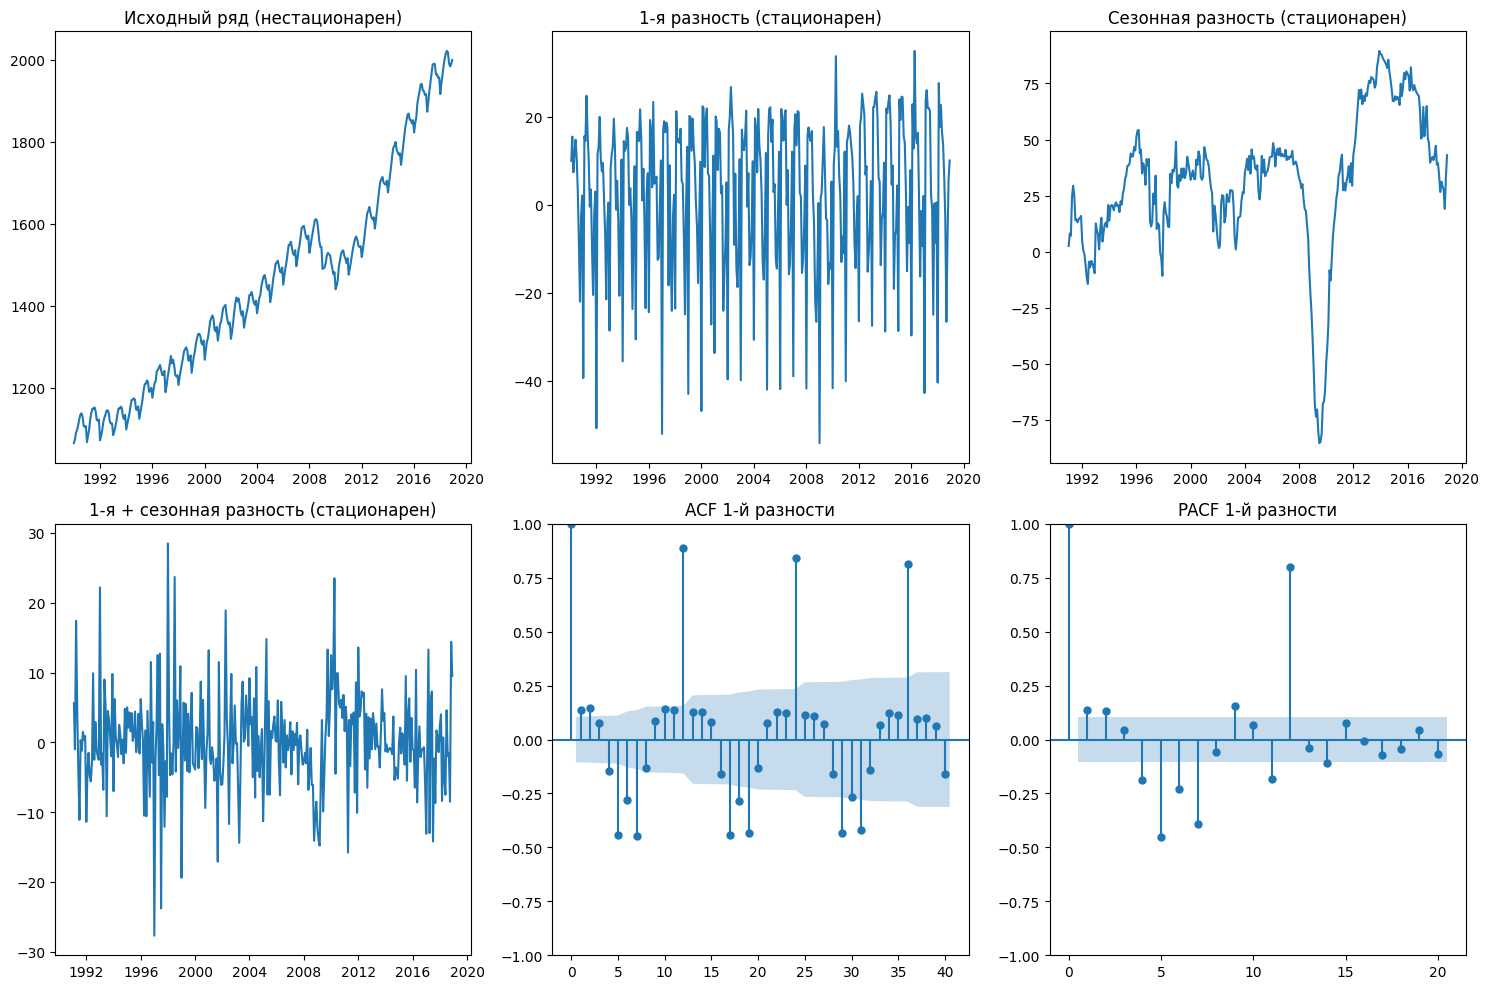

In [ ]:
def plot_stationarity_comparison(original_data):

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0,0].plot(original_data)
    axes[0,0].set_title('Исходный ряд (нестационарен)')

    diff_1 = original_data.diff().dropna()
    axes[0,1].plot(diff_1)
    axes[0,1].set_title('1-я разность (стационарен)')

    seasonal_diff = original_data.diff(12).dropna()
    axes[0,2].plot(seasonal_diff)
    axes[0,2].set_title('Сезонная разность (стационарен)')

    diff_1_seasonal = original_data.diff().diff(12).dropna()
    axes[1,0].plot(diff_1_seasonal)
    axes[1,0].set_title('1-я + сезонная разность (стационарен)')

    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(diff_1, ax=axes[1,1], lags=40)
    axes[1,1].set_title('ACF 1-й разности')

    from statsmodels.graphics.tsaplots import plot_pacf
    plot_pacf(diff_1, ax=axes[1,2], lags=20)
    axes[1,2].set_title('PACF 1-й разности')

    plt.tight_layout()
    plt.show()

plot_stationarity_comparison(df)

## Построение модели прогнозирования

Разбиение на трейн/тест (берем 12 мес., тк цикл)

In [ ]:
H_TEST = 12
train = df.iloc[:-H_TEST].copy()
test  = df.iloc[-H_TEST:].copy()

y_train = np.log(train["y"]) if do_log else train["y"]

print(f"Длина train: {len(train)}, длина test: {len(test)}")


Длина train: 336, длина test: 12


**Построение SARIMA**

In [ ]:
d, D, s = 1, 0, 12
best_aic, best_cfg, best_res = np.inf, None, None

for p in [0,1,2,3]:
    for q in [0,1,2,3]:
        for P in [0,1]:
            for Q in [0,1]:
                order = (p, d, q)
                seas  = (P, D, Q, s)
                try:
                    res = SARIMAX(y_train,
                                  order=order,
                                  seasonal_order=seas,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False).fit(disp=False)
                    if res.aic < best_aic:
                        best_aic, best_cfg, best_res = res.aic, (order, seas), res
                except Exception:
                    pass

print("Лучшая модель:", best_cfg, "AIC:", best_aic)

Лучшая модель: ((2, 1, 1), (1, 0, 1, 12)) AIC: -2629.398827069288


AIC - показывает хороший результат

**Оцениваем точность прогноза (MAE + RMSE)**

In [ ]:
pred_test = best_res.get_forecast(steps=H_TEST).summary_frame(alpha=0.05)
y_pred = pred_test["mean"]
ci_lo  = pred_test["mean_ci_lower"]
ci_hi  = pred_test["mean_ci_upper"]

if do_log:
    y_pred = np.exp(y_pred); ci_lo = np.exp(ci_lo); ci_hi = np.exp(ci_hi)

mae  = mean_absolute_error(test["y"], y_pred)
rmse = math.sqrt(mean_squared_error(test["y"], y_pred))
print(f"Метрики (test, 12 мес.):  MAE = {mae:.2f},  RMSE = {rmse:.2f}")


Метрики (test, 12 мес.):  MAE = 7.85,  RMSE = 10.34


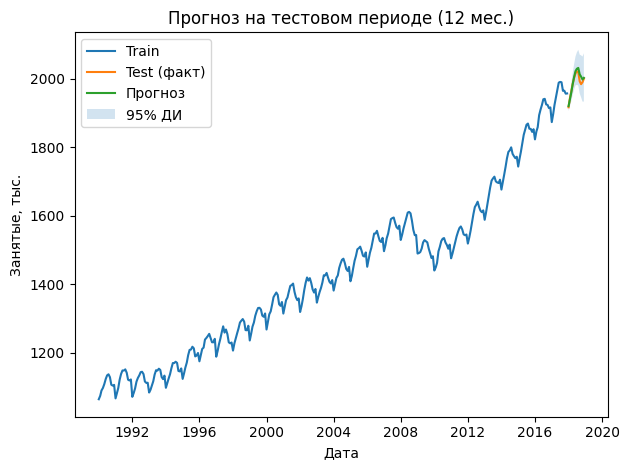

In [ ]:

plt.figure()
plt.plot(train.index, train["y"], label="Train")
plt.plot(test.index,  test["y"],  label="Test (факт)")
plt.plot(test.index,  y_pred,     label="Прогноз")
plt.fill_between(test.index, ci_lo, ci_hi, alpha=0.2, label="95% ДИ")
plt.title("Прогноз на тестовом периоде (12 мес.)")
plt.xlabel("Дата"); plt.ylabel("Занятые, тыс.")
plt.legend(); plt.tight_layout(); plt.show()


результат хороший

**Делаем прогноз на 1 год вперед, для достоверности**

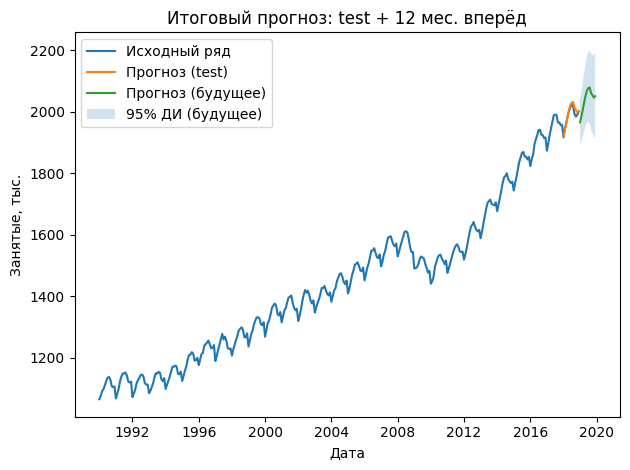

In [ ]:
FUTURE_STEPS = 12
pred_all = best_res.get_forecast(steps=H_TEST + FUTURE_STEPS).summary_frame(alpha=0.05)

f_mean = pred_all["mean"].iloc[-FUTURE_STEPS:]
f_lo   = pred_all["mean_ci_lower"].iloc[-FUTURE_STEPS:]
f_up   = pred_all["mean_ci_upper"].iloc[-FUTURE_STEPS:]

if do_log:
    f_mean = np.exp(f_mean); f_lo = np.exp(f_lo); f_up = np.exp(f_up)

future_index = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(1), periods=FUTURE_STEPS, freq="MS")

plt.figure()
plt.plot(df.index, df["y"], label="Исходный ряд")
plt.plot(test.index, y_pred, label="Прогноз (test)")
plt.plot(future_index, f_mean.values, label="Прогноз (будущее)")
plt.fill_between(future_index, f_lo.values, f_up.values, alpha=0.2, label="95% ДИ (будущее)")
plt.title("Итоговый прогноз: test + 12 мес. вперёд")
plt.xlabel("Дата"); plt.ylabel("Занятые, тыс.")
plt.legend(); plt.tight_layout(); plt.show()


Тоже хороший результат

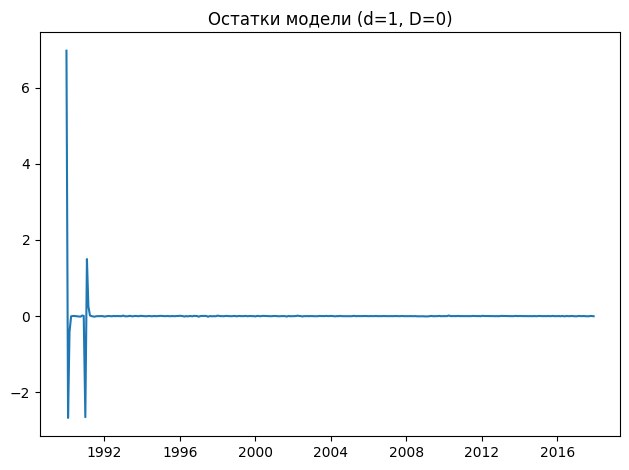

<Figure size 640x480 with 0 Axes>

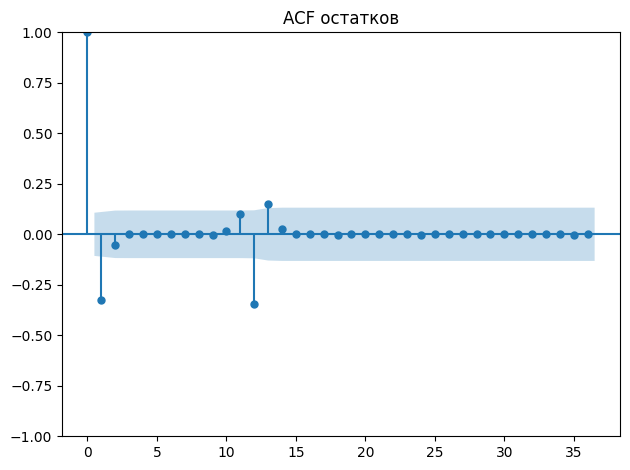

In [ ]:
resid = best_res.resid

plt.figure(); plt.plot(resid)
plt.title("Остатки модели (d=1, D=0)")
plt.tight_layout(); plt.show()

plt.figure(); plot_acf(resid.dropna(), lags=36)
plt.title("ACF остатков")
plt.tight_layout(); plt.show()


График остатков: Отсутвует систематическое смещение, нет янвыйх трендов и нет сезонности

ACF: нет значимой автокорреляции нет сезонных пиков.

ИТОГО

1) Первая разность (d=1) обеспечивает стационарность
2) Модель подобрана SARIMA с d=1, D=0, s=12
3) Качество: приведены MAE/RMSE на 12-месячном тесте
4) Интерпретация тренд лонгой
5) Ограничения при структурных сдвига точность падает

искали медь, а нашли золото